In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)
from utils import interpret_output, draw_result
from object_detection_server import Detector, serve

In [2]:
config = dict()
# display layer information
config['verbose'] = False
config['weights_file']='YOLO_tensorflow/weights/YOLO_small.ckpt'

### Define Basic NN Layers

In [3]:
def conv_layer(inputs, filters, size, stride, alpha=0.1, name=''):
    # compute shapes
    channels = int(inputs.get_shape()[3])
    pad_size = size//2
    pad_mat = np.array([[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]])
    inputs_pad = tf.pad(inputs, pad_mat)
    # intialize weights
    weight = tf.Variable(tf.truncated_normal([size,size, channels, filters], stddev=0.1))
    biases = tf.Variable(tf.constant(0.1, shape=[filters]))
    # construct convolution+bias+ReLU layer
    conv = tf.nn.conv2d(inputs_pad, weight, strides=[1, stride, stride, 1], padding='VALID', name=name+'_conv')
    conv_biased = tf.add(conv, biases, name=name+'_conv_biased')
    conv_biased_relu = tf.maximum(alpha*conv_biased, conv_biased, name=name+'_leaky_relu')
    if config['verbose']:
        print('\tLayer {}: Type = Conv, Size = {} * {}, Stride = {}, Filters = {}, Input channels = {}'
              .format(name, size, size, stride, filters, channels))
    return conv_biased_relu

In [4]:
def pooling_layer(inputs, size, stride, name=''):
    max_pooling = tf.nn.max_pool(inputs, ksize=[1, size, size, 1], strides=[1, stride, stride, 1], padding='SAME',
                                name=name+'_pool')
    if config['verbose']: 
        print('\tLayer {}: Type = Pool, Size = {} * {}, Stride = {}'.format(name, size, size, stride))
    return max_pooling

In [5]:
def fc_layer(inputs, hiddens, flat=False, linear=False, alpha=0.1, name=''):
    # compute shapes
    input_shape = inputs.get_shape().as_list()
    if flat:
        dim = input_shape[1]*input_shape[2]*input_shape[3]
        inputs_transposed = tf.transpose(inputs, (0, 3, 1, 2))
        inputs_processed = tf.reshape(inputs_transposed, [-1, dim])
    else:
        dim = input_shape[1]
        inputs_processed = inputs
    # initialize weights
    weight = tf.Variable(tf.truncated_normal([dim, hiddens], stddev=0.1))
    biases = tf.Variable(tf.constant(0.1, shape=[hiddens]))
    # construct fc layer
    if linear:
        fc = tf.add(tf.matmul(inputs_processed, weight), biases, name=name+'_fc')
    else:
        ip = tf.add(tf.matmul(inputs_processed, weight), biases)
        # add non-linear: leaky ReLU
        fc = tf.maximum(alpha*ip, ip, name=name+'_fc')
    if config['verbose']:
        print('\tLayer {}: Type = Full, Hidden = {}, Input dimension = {}, Flat = {}, Activation = {}'
              .format(name, hiddens, int(dim), int(flat), 1-int(linear)))
    return fc

### YOLO Network (small version) Constructor

In [6]:
def build_YOLO_small():
    if config['verbose']:
        print('Building YOLO_small graph...')
    inp = tf.placeholder('float32', [None, 448, 448, 3])
    conv_1 = conv_layer(inp, 64, 7, 2, name='1')
    pool_2 = pooling_layer(conv_1, 2 ,2, name='2')
    conv_3 = conv_layer(pool_2, 192, 3, 1, name='3')
    pool_4 = pooling_layer(conv_3, 2, 2, name='4')
    conv_5 = conv_layer(pool_4, 128, 1, 1, name='5')
    conv_6 = conv_layer(conv_5, 256, 3, 1, name='6')
    conv_7 = conv_layer(conv_6, 256, 1, 1, name='7')
    conv_8 = conv_layer(conv_7, 512, 3, 1, name='8')
    pool_9 = pooling_layer(conv_8, 2, 2, name='9')
    conv_10 = conv_layer(pool_9, 256, 1, 1, name='10')
    conv_11 = conv_layer(conv_10, 512, 3, 1, name='11')
    conv_12 = conv_layer(conv_11, 256, 1, 1, name='12')
    conv_13 = conv_layer(conv_12, 512, 3, 1, name='13')
    conv_14 = conv_layer(conv_13, 256, 1, 1, name='14')
    conv_15 = conv_layer(conv_14, 512, 3, 1, name='15')
    conv_16 = conv_layer(conv_15, 256, 1, 1, name='16')
    conv_17 = conv_layer(conv_16, 512, 3, 1, name='17')
    conv_18 = conv_layer(conv_17, 512, 1, 1, name='18')
    conv_19 = conv_layer(conv_18, 1024 ,3, 1, name='19')
    pool_20 = pooling_layer(conv_19, 2, 2, name='20')
    conv_21 = conv_layer(pool_20, 512, 1, 1, name='21')
    conv_22 = conv_layer(conv_21, 1024, 3, 1, name='22')
    conv_23 = conv_layer(conv_22, 512, 1, 1, name='23')
    conv_24 = conv_layer(conv_23, 1024, 3, 1, name='24')
    conv_25 = conv_layer(conv_24, 1024, 3, 1, name='25')
    conv_26 = conv_layer(conv_25, 1024, 3, 2, name='26')
    conv_27 = conv_layer(conv_26, 1024, 3, 1, name='27')
    conv_28 = conv_layer(conv_27, 1024, 3, 1, name='28')
    fc_29 = fc_layer(conv_28, 512, flat=True, linear=False, name='29')
    fc_30 = fc_layer(fc_29, 4096, flat=False, linear=False, name='30')
    # skip dropout_31 (only used in training)
    fc_32 = fc_layer(fc_30, 1470, flat=False, linear=True, name='32')
    
    return {'input': inp, 'model': fc_32}

In [7]:
with tf.device('/cpu:0'):
    net = build_YOLO_small()

### Define Detector

In [8]:
class YOLODetector():
    def __init__(self, net):
        self.net = net
        self.sess = tf.Session()
        tf.global_variables_initializer()
        saver = tf.train.Saver()
        saver.restore(self.sess, config['weights_file'])
    
    def detect(self, img):
        h_img, w_img, _ = img.shape
        img_resized = cv2.resize(img, (448, 448))
        img_RGB = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_resized_np = np.asarray(img_RGB)
        inputs = np.zeros((1, 448, 448, 3), dtype='float32')
        inputs[0] = (img_resized_np/255.0)*2.0-1.0
        output = self.sess.run(self.net['model'], feed_dict={self.net['input']: inputs})
        result = interpret_output(output[0], w_img, h_img, threshold=0.2, iou_threshold=0.5)
        result_img = draw_result(img, result)
        return result_img

In [9]:
if not 'yolo_detector' in globals():
    yolo_detector = YOLODetector(net)

INFO:tensorflow:Restoring parameters from YOLO_tensorflow/weights/YOLO_small.ckpt


### Main Loop

In [ ]:
serve(Detector(yolo_detector))

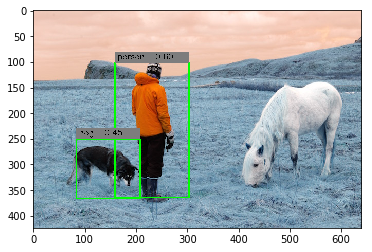

In [11]:
img = cv2.imread('YOLO_tensorflow/test/person.jpg')
result = yolo_detector.detect(img)
plt.imshow(result)
plt.show()